In [5]:
#!/usr/bin/env python

# coding: utf-8

# %% Loading Packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
# from sklearn.metrics import mean_squared_error, mean_absolute_erIPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')ror

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.activations import tanh
from tensorflow.keras.layers import PReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import MSE, MAE, MAPE
from tensorflow.keras.metrics import Accuracy, SparseCategoricalAccuracy
from tensorflow.keras.losses import kullback_leibler_divergence, SparseCategoricalCrossentropy, KLDivergence
from tensorflow.keras.callbacks import LearningRateScheduler

import sys

from tensorflow.python.ops.gen_batch_ops import batch

import sys
import os
import sys
import platform

from tensorflow.python.ops.gen_math_ops import Tanh
if platform.node() in ['msbq', 'msdai']:
    os.chdir('/home/ms/github/fxpred')
    sys.path.append(os.path.join(os.getcwd(), 'Transformer'))
else:
    os.chdir('/home/RDC/fisertiz/Schreibtisch/phd/paper1_fxpred')
    sys.path.append(os.path.join(os.getcwd(), 'Transformer'))
from utils import get_fx_and_metric_data_wo_weekend, mde
from utils_NN_opt_learning_rate import opt_learn_rate_plot
from benchmark_utils import actual_pred_plot, ts_train_test_normalize, predictions2
from transformer_architecture_elements import Time2Vector, SingleAttention, MultiAttention, TransformerEncoder

In [6]:
filename_history = 'Benchmark/trained_models/LSTM_multivariate_EURUSD_1hData____history.pkl'  # Classification model
epoch = f"{np.argmin(pd.read_pickle(filename_history)['val_loss']):04}"
# epoch = '0100'
filename = filename_history.split('____')[0] + '____' + epoch + '.hdf5'
if 'GBPUSD' in filename_history:
    target = 'GBPUSD'
elif 'USDJPY' in filename_history:
    target = 'USDJPY'
else:
    target = 'EURUSD'
target_price = target = target + ' BGNE Curncy Bid Close'
print(filename)
print(target)
print(f'Epoch: {epoch}')

Benchmark/trained_models/LSTM_multivariate_EURUSD_1hData____0062.hdf5
EURUSD BGNE Curncy Bid Close
Epoch: 0062


In [7]:
my_LSTM_model = tf.keras.models.load_model(
    filename,
    custom_objects={
        'kl_divergence': kullback_leibler_divergence,
        'Time2Vector': Time2Vector,
        'SingleAttention': SingleAttention,
        'MultiAttention': MultiAttention,
        'TransformerEncoder': TransformerEncoder
    }
)
lag = my_LSTM_model.input_shape[1]
print(f'lag: {lag}')
if my_LSTM_model.layers[-1].activation == tf.keras.activations.softmax:
    nn_type_classification = True
    h = 1
else:
    nn_type_classification = False
    h = my_LSTM_model.output_shape[1]
print(f'h: {h}')
print(nn_type_classification)

lag: 128
h: 1
False


In [8]:
dtype = np.float32  # np.float64
tf.keras.backend.set_floatx('float32')

In [9]:
# %% read in data and adapt
from utils import data_merge, data_read_dict
def __get_fx_and_metric_data_wo_weekend(
    *,
    pct_change:bool=True,
    dtype:np.float=None,
    directory='data',
    directory_metrics=None,
    sep=',',
    enddate='2022-02-01'
) -> pd.DataFrame:
    """Gets the FX spot rates and combines data with metrics, without missing values on weekends (and bank holidays).

    Args:
        pct_change (bool, optional): Returns percantage change. Defaults to True.
        dtype (numpy.float, optional): data type of data, options 'numpy.floatX'. Defaults to None.

    Returns:
        pd.DataFrame: Spot rates and metrics in one pandas.DataFrame
    """
    path = os.path.join(directory, '10min Dataset Spot.csv')
    df = pd.read_csv(path, delimiter=sep)
    df['Dates'] = pd.to_datetime(df['Dates'], format='%d.%m.%y %H:%M')
    df.set_index('Dates', inplace=True)
    # df = df.asfreq('600S')
    if pct_change:
        df = df.pct_change()[1:]
    # assert len(set(np.diff(df.index.values))) == 1

    FX_Fundamentals_path = os.path.join(directory, '10min Dataset Rest.csv')
    df2 = pd.read_csv(FX_Fundamentals_path, delimiter=sep)
    df2.replace(to_replace=0, method='ffill', inplace=True) # Replace 0 to avoid dividing by 0 later on
    df2.drop('UXA1 Comdty Trade Open', axis=1, inplace=True)
    df2['Dates'] = pd.to_datetime(df2['Dates'], format='%d.%m.%y %H:%M')
    df2.sort_values('Dates', inplace=True)
    df2.sort_values('Dates')
    df2.index = df2['Dates']

    # df3
    df3 = pd.merge(df, df2, left_index=True, right_index=True)
    df3['Dates'] = pd.to_datetime(df3['Dates'], format='%d.%m.%y %H:%M')
    df3.index = df3['Dates']

    df_metrics = data_merge(data_read_dict(os.path.join(directory_metrics, 'bbg')))
    df_metrics.shape
    # excluding eurgbp for now
    df_metrics = df_metrics.loc[:, [i for i in df_metrics.columns if i.split('___')[0].lower() != 'eurgbp']]
#     df_merged = pd.merge(df3, df_metrics, left_index=True, right_index=True, how='outer')
    df_merged = df3.join(df_metrics)
    
    # Deleting all rows that have missing values in df and df2 columns
    df_merged = df_merged.loc[~df_merged.loc[:, set(df.columns.append(df2.columns))].isna().all(axis=1)]

    # Deleting all columns with duplicated data that occur on the weekend
    #(np.diff(df_merged.loc[:, df.columns], prepend=-9999) == 0).mean(axis=1) < 0.95
    duplicates = df_merged.loc[:, df.columns].duplicated()
    weekend = [i.weekday() in [5, 6] for i in df_merged.index]
    # sum(duplicates)
    # sum(weekend)
    # sum(duplicates & weekend)
    # sum(duplicates | weekend)
    df_merged = df_merged.loc[~(duplicates & weekend), :]

    df = df_merged[:]
    df.drop('Dates', axis=1, inplace=True)
    # df = df.asfreq('600S')
    df = df.ffill()
    df = df.loc[(df.index >= '2020-11-01') & (df.index < enddate), :]
    #TODO: There will still be NA values (metric values) in the beginning, possible fixes:
    df = df.bfill()  # back fill
    # df.dropna(how='all', axis=0, inplace=True)  # Drop all rows with NaN values"
    # df.fillna(0, inplace=True)  # impute all NaNs with 0
    df = df.astype(dtype)    
    del df_merged, df2, df3
    return df
df = __get_fx_and_metric_data_wo_weekend(dtype=np.float32, directory='data/1h_Dataset', directory_metrics='data')

/home/ms/github/venv/fxpred3/lib/python3.8/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [10]:

df_close = get_fx_and_metric_data_wo_weekend(dtype=dtype, pct_change=False)
target_column = list(df.columns).index(target)
if my_LSTM_model.input_shape[-1] <= 2:
    df = df.iloc[:, target_column : target_column + 1]
target_column = list(df.columns).index(target)
target_price_column = target_column
print(df.shape)
df.head()

(8083, 1236)


,EURUSD BGNE Curncy Bid Open,EURUSD BGNE Curncy Bid Close,EURUSD BGNE Curncy Bid High,EURUSD BGNE Curncy Bid Low,EURUSD BGNE Curncy Bid Number Ticks,EURUSD BGNE Curncy Ask Open,EURUSD BGNE Curncy Ask Close,EURUSD BGNE Curncy Ask High,EURUSD BGNE Curncy Ask Low,EURUSD BGNE Curncy Ask Number Ticks,...,usdjpy___TAS_K,usdjpy___TAS_D,usdjpy___TAS_DS,usdjpy___TAS_DSS,usdjpy___TRENDER_UP,usdjpy___TRENDER_DN,usdjpy___TMAVG,usdjpy___VMAVG,usdjpy___WMAVG,usdjpy___WLPR
Dates,,,,,,,,,,,,,,,,,,,,,
2020-11-01 20:00:00,0.000180,-0.000009,-0.000026,-0.000137,-0.915625,0.001263,0.000103,0.000807,0.000636,-0.915625,...,50.0,58.000000,77.555557,72.385185,104.541634,104.576935,104.553337,104.62204,104.552002,-60.0
2020-11-01 21:00:00,0.000009,0.000000,-0.000215,0.000069,-0.061728,-0.000558,0.000034,0.000017,0.000077,-0.061728,...,50.0,58.000000,77.555557,72.385185,104.541634,104.576935,104.548889,104.62204,104.549332,-60.0
2020-11-01 22:00:00,0.000017,0.000137,0.000283,-0.000610,1.710526,0.000335,0.000429,0.000652,-0.000009,1.710526,...,50.0,58.000000,77.555557,72.385185,104.541634,104.576935,104.554443,104.62204,104.555336,-60.0
2020-11-01 23:00:00,0.000240,0.000155,0.000060,0.000739,1.009709,-0.000197,-0.000429,-0.000780,-0.000043,1.009709,...,50.0,58.000000,77.555557,72.385185,104.541634,104.576935,104.572220,104.62204,104.571335,-50.0
2020-11-02 00:00:00,-0.000335,-0.000472,-0.000292,-0.000198,2.507246,-0.000652,-0.000687,-0.000978,-0.000807,2.507246,...,80.0,87.111115,77.555557,72.385185,104.561470,104.576935,104.625557,104.62204,104.636665,-20.0


In [11]:
def strategy(x):
    conditions = [
        (x <= -0.00000001),
        (x > -0.00000001) & (x <= 0.00000001),
        (x > 0.00000001)
    ]

    # create a list of the values we want to assign for each condition #!!! 
    values = ['sell', 'hold', 'buy']
    values = [0, 1, 2]

    # create a new column and use np.select to assign values to it using our lists as arguments #!!! 
    return np.select(conditions, values).astype(np.int32)
if nn_type_classification:
    df['strategy'] = strategy(df[target_price])
    target = 'strategy'
target_column = df.columns.to_list().index(target)

In [12]:
df.head()

,EURUSD BGNE Curncy Bid Open,EURUSD BGNE Curncy Bid Close,EURUSD BGNE Curncy Bid High,EURUSD BGNE Curncy Bid Low,EURUSD BGNE Curncy Bid Number Ticks,EURUSD BGNE Curncy Ask Open,EURUSD BGNE Curncy Ask Close,EURUSD BGNE Curncy Ask High,EURUSD BGNE Curncy Ask Low,EURUSD BGNE Curncy Ask Number Ticks,...,usdjpy___TAS_K,usdjpy___TAS_D,usdjpy___TAS_DS,usdjpy___TAS_DSS,usdjpy___TRENDER_UP,usdjpy___TRENDER_DN,usdjpy___TMAVG,usdjpy___VMAVG,usdjpy___WMAVG,usdjpy___WLPR
Dates,,,,,,,,,,,,,,,,,,,,,
2020-11-01 20:00:00,0.000180,-0.000009,-0.000026,-0.000137,-0.915625,0.001263,0.000103,0.000807,0.000636,-0.915625,...,50.0,58.000000,77.555557,72.385185,104.541634,104.576935,104.553337,104.62204,104.552002,-60.0
2020-11-01 21:00:00,0.000009,0.000000,-0.000215,0.000069,-0.061728,-0.000558,0.000034,0.000017,0.000077,-0.061728,...,50.0,58.000000,77.555557,72.385185,104.541634,104.576935,104.548889,104.62204,104.549332,-60.0
2020-11-01 22:00:00,0.000017,0.000137,0.000283,-0.000610,1.710526,0.000335,0.000429,0.000652,-0.000009,1.710526,...,50.0,58.000000,77.555557,72.385185,104.541634,104.576935,104.554443,104.62204,104.555336,-60.0
2020-11-01 23:00:00,0.000240,0.000155,0.000060,0.000739,1.009709,-0.000197,-0.000429,-0.000780,-0.000043,1.009709,...,50.0,58.000000,77.555557,72.385185,104.541634,104.576935,104.572220,104.62204,104.571335,-50.0
2020-11-02 00:00:00,-0.000335,-0.000472,-0.000292,-0.000198,2.507246,-0.000652,-0.000687,-0.000978,-0.000807,2.507246,...,80.0,87.111115,77.555557,72.385185,104.561470,104.576935,104.625557,104.62204,104.636665,-20.0


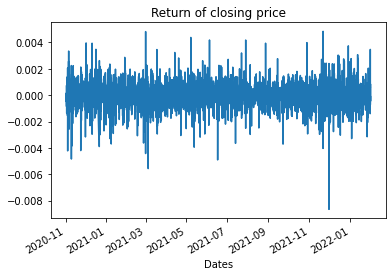

In [13]:
df[target_price].plot()
plt.title('Return of closing price')
plt.show()

In [14]:
X_train, y_train, X_val, y_val , X_test, y_test, sc, sc_target, index_train, index_val, index_test, X_train_index, y_train_index = \
    ts_train_test_normalize(df, lag, h, target_column)

In [15]:
if nn_type_classification:
    y_train = sc_target.inverse_transform(y_train)
    y_val = sc_target.inverse_transform(y_val)
    y_test = sc_target.inverse_transform(y_test)

## Econmetric measures

Definition of cumulated returns

In [16]:
def cumulated_return(y_pred, ret, start_capital=1000, dtype=None):
    assert y_pred.flatten().shape == ret.flatten().shape
    balance = [start_capital]
    signal = 0
    for i, d in enumerate(y_pred[:-1]):
        signal = signal if d == 1 else d
        if signal == 0:
            balance.append(balance[-1])
        elif signal == 2:
            balance.append(balance[-1] * ret[i])
        else:
            raise ValueError()
    balance = np.array(balance, dtype=dtype)
    return balance

In [17]:
# #!!! for testing purposes
# tmp_type = 'train'

# X = np.concatenate([sc.inverse_transform(i)[np.newaxis] for i in eval(f"X_{tmp_type}")], axis=0)
# for i in range(lag):
#     diff = np.abs(df.loc[eval(f"index_{tmp_type}")].iloc[i:-(lag - i + 1)].values - X[:,-(lag - i)]).sum(axis=0)
#     assert diff[0] < 1e-6 and diff[1] < 0.5, 'df and X inversed are not the same'

# X_ret_testing = np.concatenate([sc.inverse_transform(i)[np.newaxis] for i in eval(f"X_{tmp_type}")], axis=0)[:, -1, 0]
# y_testing = np.concatenate([sc.inverse_transform(i)[np.newaxis] for i in eval(f"X_{tmp_type}")], axis=0)[:, -1, 1]

# a1 = sc_target.inverse_transform(eval(f"y_{tmp_type}")).flatten()
# a2 = eval(f"y_{tmp_type}").flatten()
# b = np.concatenate([sc.inverse_transform(i)[np.newaxis] for i in eval(f"X_{tmp_type}")], axis=0)[:, -1, 1]
# cc = df.loc[eval(f"index_{tmp_type}")].iloc[(lag - 1):-(h+1), 1].values
# print(np.abs(cc[1:] - a1[:-1]).sum(axis=0))
# print(np.abs(cc[1:] - a2[:-1]).sum(axis=0))
# print(np.abs(cc - b).sum(axis=0))

In [18]:
print((index_train[0:-(lag+1)] == X_train_index[:, 0]).all())
print((index_train[(lag-1):-(h+1)] == X_train_index[:, -1]).all())

True
True


## read in data for econmic metric

In [19]:
def econ_metrics(y_pred, X_ret, risk_free=0.0031):  # Risk free rate must be given
    x = cumulated_return(y_pred[:-1], X_ret[1:], dtype=dtype)
    print(f'Portfolio return: {x[-1] / x[0] - 1}')
    print(f'Std of returns: {np.std(x[1:] / x[:-1])}')
    print(f'Sharpe ratio: {((x[-1] / x[0]) - 1 - risk_free) / np.std(x[1:] / x[:-1])}')
    print()
    
    n = 6 * 24 * 252  # banking days per year
    mu_annum = ((x[-1]/x[0]) ** (n / x.shape[0])) - 1
    print(f'Return per annum: {mu_annum}')
    std_annum = np.std(x[1:] / x[:-1]) * (n)**0.5
    print(f'Std of returns per annum: {std_annum}')
    print(f'Sharpe ratio per annum: {(mu_annum - risk_free) / std_annum}')

In [20]:
print(X_train.shape[-1] == my_LSTM_model.input_shape[-1])
print(X_train.shape[-1])
print(my_LSTM_model.input_shape[-1])

True
1236
1236


In [21]:
def investment_lengths(y):
    count_length = {0: [], 1: [], 2: []}
    length = 0
    current = y.flatten()[0]
    for i, t in enumerate(y.flatten()):
        if t == current:
            length += 1
        else:
            count_length[current].append(length)
            current = t
            length = 1
    return count_length
def investment_lengths_buy_sell(y):
    count_length = {0: [], 2: []}
    length = 0
    current = y.flatten()[0]
    for i, t in enumerate(y.flatten()):
        if t == current or t == 1:
            length += 1
        else:
            count_length[current].append(length)
            current = t
            length = 1
    return count_length
def changed_number_of_investments(v):
    return sum([len(v) for k, v in count_length.items()])
def investment_length_stats(v, dec_point=4):
    return {k: {'number': len(v), 'mean': np.mean(v).round(dec_point), 'std': np.std(v).round(dec_point), 'max': np.max(v)} for k, v in v.items() if v}

In [22]:
def result_output2(tmp_type):
    print(tmp_type)

    y = eval(f"y_{tmp_type}")
    if nn_type_classification:
        y_pred = np.argmax(predictions2(
            my_LSTM_model,
            eval(f"X_{tmp_type}"),
            bs=32
        ), axis=1)
    else:
        y = strategy(y)
        if X_train.shape[-1] - 1 == my_LSTM_model.input_shape[-1]:
            i = df.columns.to_list().index('strategy')
            y_pred = strategy(predictions2(
                my_LSTM_model,
                np.delete(eval(f"X_{tmp_type}"), i, -1),
                bs=32
            ))
        else:
            y_pred = strategy(predictions2(
                my_LSTM_model,
                eval(f"X_{tmp_type}"),
                bs=32
            ))
    print(f'Accuracy: {Accuracy()(y.flatten(), y_pred.flatten()).numpy()}')
    print(f'Accuracy: {SparseCategoricalAccuracy()(y.astype(dtype), y_pred.reshape(y.shape).astype(dtype)).numpy()}')
    print(f'KL_Divergence: {kullback_leibler_divergence(y.flatten().astype(dtype), y_pred.flatten().astype(dtype)).numpy()}')
    print(classification_report(y, y_pred))
    cm = confusion_matrix(y, y_pred)
    ConfusionMatrixDisplay(cm).plot()
    plt.show()

    X_ret = sc.inverse_transform(eval(f"X_{tmp_type}"))[:, -1, target_price_column] + 1
    plt.plot(eval(f"index_{tmp_type}")[lag-1:-(h+1)][1:], cumulated_return(y_pred[:-1], X_ret[1:], dtype=dtype), label='predicted')

    c = Counter(y.flatten())
    for i in range(3):
        c.update({i: 0})
    p = [i[1]/y.shape[0] for i in sorted(c.items(), key=lambda x: x[0])]
    x = np.concatenate(
        [
            cumulated_return(
                np.random.choice([0, 1, 2], size=y_pred[:-1].shape, p=p),
                X_ret[1:],
                dtype=dtype
            )[:,np.newaxis] for i in range(50)
        ], axis=-1
    )
    plt.plot(eval(f"index_{tmp_type}")[(lag-1):-(h+1)][1:], x.mean(axis=-1), label='random', color='gray')
    plt.plot(eval(f"index_{tmp_type}")[(lag-1):-(h+1)][1:], x.mean(axis=-1) + x.std(axis=-1), label='random_q75', color='gray', linestyle='--')
    plt.plot(eval(f"index_{tmp_type}")[(lag-1):-(h+1)][1:], cumulated_return(y_pred[:-1] * 0 + 2, X_ret[1:], dtype=dtype), label='buy&HODL')
    plt.plot(eval(f"index_{tmp_type}")[(lag-1):-(h+1)][1:], cumulated_return(y[:-1], X_ret[1:], dtype=dtype), label='oracle')
    plt.plot(eval(f"index_{tmp_type}")[(lag-1):-(h+1)][1:], cumulated_return(y, X_ret, dtype=dtype)[:-1], label='oracle')
    plt.legend()
    plt.semilogy()
    plt.show()
    econ_metrics(y_pred, X_ret)
    print('=============================')
    print('Investment lengths')
    print('y_true')
    print(pd.DataFrame.from_dict(investment_length_stats(investment_lengths(y)), orient='index'))
    print('y_pred')
    print(pd.DataFrame.from_dict(investment_length_stats(investment_lengths(y_pred)), orient='index'))
    print('Investment lengths for only buy and sell (hold is prolongation of previous)')
    print('y_true')
    print(pd.DataFrame.from_dict(investment_length_stats(investment_lengths_buy_sell(y)), orient='index'))
    print('y_pred')
    print(pd.DataFrame.from_dict(investment_length_stats(investment_lengths_buy_sell(y_pred)), orient='index'))

In [23]:
# result_output2('train')

test
Accuracy: 0.5051546096801758
Accuracy: 0.5051546096801758
KL_Divergence: 5415.68017578125
              precision    recall  f1-score   support

           0       0.51      1.00      0.67       343
           2       0.00      0.00      0.00       336

    accuracy                           0.51       679
   macro avg       0.25      0.50      0.34       679
weighted avg       0.26      0.51      0.34       679



/home/ms/github/venv/fxpred3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ms/github/venv/fxpred3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ms/github/venv/fxpred3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


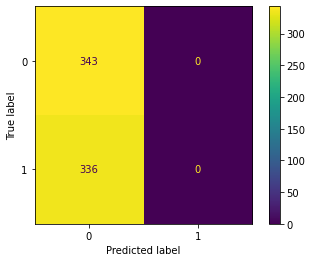

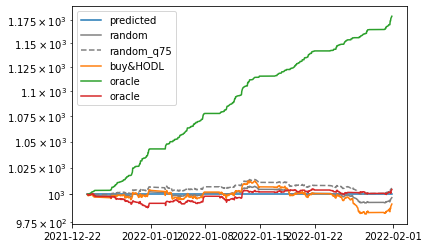

Portfolio return: 0.0
Std of returns: 0.0
Sharpe ratio: -inf

Return per annum: 0.0
Std of returns per annum: 0.0
Sharpe ratio per annum: -inf
Investment lengths
y_true
   number    mean     std  max
0     159  2.1509  1.8298   15
2     159  2.1132  1.5821   10
y_pred
Empty DataFrame
Columns: []
Index: []
Investment lengths for only buy and sell (hold is prolongation of previous)
y_true
   number    mean     std  max
0     159  2.1509  1.8298   15
2     159  2.1132  1.5821   10
y_pred
Empty DataFrame
Columns: []
Index: []


<ipython-input-19-7cccfa290d85>:5: RuntimeWarning: divide by zero encountered in double_scalars
  print(f'Sharpe ratio: {((x[-1] / x[0]) - 1 - risk_free) / np.std(x[1:] / x[:-1])}')
<ipython-input-19-7cccfa290d85>:13: RuntimeWarning: divide by zero encountered in double_scalars
  print(f'Sharpe ratio per annum: {(mu_annum - risk_free) / std_annum}')


In [24]:
result_output2('test')

train
Accuracy: 0.5197222828865051
Accuracy: 0.48516881465911865
KL_Divergence: 12346.45703125
              precision    recall  f1-score   support

           0       0.51      0.26      0.34      3075
           2       0.52      0.77      0.62      3263

    accuracy                           0.52      6338
   macro avg       0.52      0.51      0.48      6338
weighted avg       0.52      0.52      0.49      6338



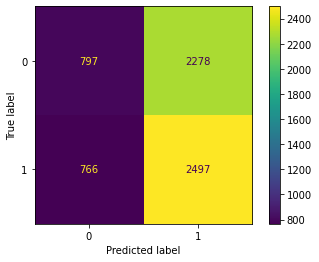

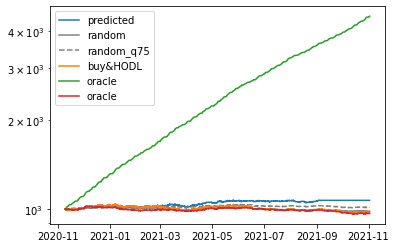

Portfolio return: 0.06988668441772461
Std of returns: 0.0006044281763024628
Sharpe ratio: 110.49565032902069

Return per annum: 0.47230899745823995
Std of returns per annum: 0.11513999807255668
Sharpe ratio per annum: 4.075117294709029
Investment lengths
y_true
   number    mean     std  max
0    1631  1.8853  1.2750   10
2    1631  1.9982  1.5043   25
y_pred
   number     mean       std   max
0      73   7.8356   11.8622    76
2      74  64.5270  247.8609  1971
Investment lengths for only buy and sell (hold is prolongation of previous)
y_true
   number    mean     std  max
0    1631  1.8853  1.2750   10
2    1631  1.9982  1.5043   25
y_pred
   number     mean       std   max
0      73   7.8356   11.8622    76
2      74  64.5270  247.8609  1971


In [25]:
result_output2('train')

In [26]:
epoch

'0062'